In [1]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import pandas as pd
import geopandas as gpd
import numpy as np

# II

# Descargo tablas de referencia
lands = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/ldown_c.csv')
countries_ref = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/countries_ref.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [2]:
# III Merging the tables

# It's neccessary to merge the databases of lands(lands types) and world (geographic reference), 
# using countries_ref as a reference table, to obtain the main df with all the necessary data.

##########################################################
# The study is done just whith the data of the 2016 year #
##########################################################
lands = lands[lands.year==2016]

# Merge the three tables:
l_c = countries_ref.merge(lands,left_on='name_l', right_on='country')
w_l_c = world.merge(l_c,
                    left_on = world['name'].str.strip().str.lower(), 
                    right_on=l_c['name_w'].str.strip().str.lower()).drop(columns=['name', 'key_0'], axis=1)


# Replace the string of types in order of simplify their names
lrep = {'Land area (thousand hectares)':'LA',
        'Arable land (thousand hectares)': 'AL', 'Arable land (% of total land area)':'AL_%',
        'Forest cover (thousand hectares)':'FC', 'Forest cover (% of total land area)':'FC_%',
        'Permanent crops (thousand hectares)':'PC','Permanent crops (% of total land area)':'PC_%',
        'Important sites for terrestrial biodiversity protected (% of total sites protected)':'IB%'}

# Main df with al the data            
w_l_c['type'] = w_l_c['type'].map(lrep)

# IV
# Creating the dataframe to calcule the main indicators
AL = w_l_c[['name_l','name_w','pop_est','value', 'geometry', 'continent']][w_l_c['type']=='AL'].rename(columns={'value':'AL'}).reset_index(drop=True)
PC = w_l_c[['value']][w_l_c['type']=='PC'].rename(columns={'value':'PC'}).reset_index(drop=True)
LA = w_l_c[['value']][w_l_c['type']=='LA'].rename(columns={'value':'LA'}).reset_index(drop=True)

w_land = pd.concat([AL, PC, LA], axis=1, join='inner')

for name in ('name_w','name_l'):
    w_land[name] = w_land[name].str.strip()
    #w_land['name_l'] = w_land['name_l'].str.strip()


def noNaN(df,values):
    for v in values:
        df[values] = df[values].replace(np.nan, 0)
        return df[values]

noNaN(w_land,['AL','PC','LA'])

# V
# Creating the indicators:
# CL, CL%(AL + PC), 'pop_est%', 'density' and 'density_CL', HpF, ref, ind
w_land['CL']= w_land['AL']+w_land['PC']
w_land['CL%']= 100*w_land['CL']/w_land['LA']
w_land['pop_est%'] = 100* w_land['pop_est']/w_land['pop_est'].sum()
w_land['density'] = (w_land['pop_est']/4)/(0.1 + w_land['LA']*1000)
w_land['density_CL'] = (w_land['pop_est']/4)/(0.1+w_land['CL']*1000)

ref_val = 1 #---->> Ha Reference Value!!!!

w_land['HpF'] = (4000) * w_land['CL']/w_land['pop_est']
w_land['ref'] = w_land['HpF'] - ref_val
w_land = w_land.sort_values(by=['continent', 'ref']).reset_index(drop=True)
w_land['name_l']= w_land['name_l'].str.capitalize()
w_land['ind'] = w_land['HpF'].apply(lambda x: 'over' if x >=ref_val else 'under')

## Exceptions:
w_land = w_land[~w_land['name_w'].str.contains('falkland is.|n. cyprus')] 


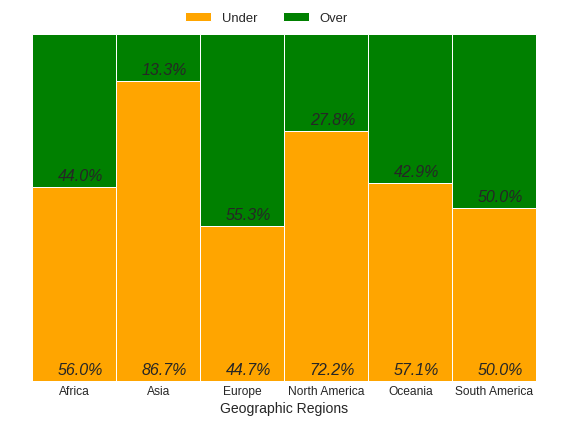

In [3]:
# XII
# Summary of world values
%matplotlib inline

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'ytick.labelleft':'off',
                     'axes.labelsize':14,
                     'xtick.labelsize':12
                    })

r = w_land['continent'].unique()

coli = ['continent', 'ind', 'HpF']
pv = w_land[coli]
pv = pv.groupby(['continent','ind']).count()
pv['%'] = pv.groupby(level=0).apply(lambda x:  100*x / x.sum())

fig= plt.figure(figsize=(8,6))

# Defino los grupos a graficar según 'over' or 'under'
overbar = pv['%'][pv.index.isin(['over'], level=1)].to_list()
underbar = pv['%'][pv.index.isin(['under'], level=1)].to_list()

# Defino parámetros del gráfico
barWidth = 1

# Create over bars
nu = plt.bar(r, underbar, color='orange', edgecolor='white', width=barWidth, label="Under")
no = plt.bar(r, overbar, bottom=underbar, color='green', edgecolor='white', width=barWidth, label="Over" )

plt.box(on=None)

# Custom x axis
plt.xticks(r, w_land['continent'].unique())
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel("Geographic Regions")

# Add a legend
plt.legend(ncol=2, fontsize=13, bbox_to_anchor=(0.3,0.95))

for n in range(6):
    plt.text(nu.patches[n].xy[0]+0.3, nu.patches[n].xy[1]+2, str(round(underbar[n],1))+'%', fontsize=16, fontstyle='oblique')
    plt.text(no.patches[n].xy[0]+0.3, no.patches[n].xy[1]+2, str(round(overbar[n],1))+'%', fontsize=16, fontstyle='oblique')
    
# Y axis in percentage
fmt = '%.0f%%'
yticks = ticker.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)


# To fix the plot size to the layout 
plt.tight_layout()

# Show graphic
plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/HpF_bars.png')